# 6 DOF analysis of the 2018 gulf of alaska earthquake
In this notebook, you will learn how to process six degree-of-freedom ground-motion data comprised of three components of translational motion and three components of rotational motion. The data used in this tutorial was recorded on the large ring laser gyroscope ROMY in Germany (http://www.romy-erc.eu), after the 2018 M7.9 gulf of Alaska earthquake as described in the accompanying paper:  

Sollberger, D., Igel, H., Schmelzbach, C., Edme, P., van Manen, D.-J., Bernauer, F., Yuan, S., Wassermann, J., Schreiber, U., and Robertsson, J. O. A. (2020): **Seismological processing of six degree-of-freedom ground-motion data**, *Sensors*.

Please refer to this paper for further details on the algorithm used for the analysis. Additional information on 6DOF polarization analysis can be found in the following publication:

Sollberger, D., Greenhalgh, S. A., Schmelzbach, C., Van Renterghem, C., and Robertsson, J. O. A. (2018): **6-C polarization analysis using point measurements of translational and rotational ground-motion: theory and applications**, *Geophysical Journal International*, 213(1), https://doi.org/10.1093/gji/ggx542.

Note that at the time of publication, the underlying code used in this analysis is still under development and some features might not yet work as intended. If you encounter any bugs or problems, please report them. You can also directly propose changes via a pull request. Any queries about this code should be directed to David Sollberger, Institute of Geophysics, ETH Zurich (david.sollberger@erdw.ethz.ch). 

## Dependencies
The code requires a few dependencies:
- Obspy (Python framework for processing of seismological data)
- PyTables
- tqdm (Progress bar)

We recommend to install them using anaconda in a new environment via:

$ conda config --add channels conda-forge # This adds the conda-forge channel to your Anaconda configuration

$ conda create -n 6DOF python=3.7 obspy pytables tqdm jupyter

$ conda activate 6DOF

## 6DOF analysis

We start by importing some of the modules that we need:

In [1]:
%matplotlib inline
import pol6C as pr # This is the main module used for 6DOF polarization analysis
import numpy as np
from obspy import read
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

Now, we read in the 6DOF data and apply some basic pre-processing to it using some standard ObsPy functions:

In [7]:
traN = read("BW.ROMY.11.TLN.2018.023") # Translational North component
traE = read("BW.ROMY.11.TLE.2018.023") # Translational East component
traZ = read("BW.ROMY.11.TLZ.2018.023") # Translational West component
rotN = read("BW.ROMY.11.RTN.2018.023") # Rotational North component
rotE = read("BW.ROMY.11.RTE.2018.023") # Rotational East component
rotZ = read("BW.ROMY.11.RTZ.2018.023") # Rotational West component

data = [traN, traE, traZ, rotN, rotE, rotZ]

for stream in data:
    stream.detrend('spline', order=5, dspline=100) # Detrend the data
    stream.trim(starttime=stream[0].stats.starttime, endtime=stream[0].stats.endtime - 4500) # We cut 4500 seconds from the end of the data to decrease the computational complexity of the analysis
    stream.taper(0.2)# Taper the data to avoid artifacts in the S-transform





Let us know have a look at our data (Fig. 2 in the accompanying paper). The time series are already corrected for the instrument response, so that the data is given in acceleration (in m/s/s) for the translational motions and rotation rate (rad/s) for the rotational motions. 

In [ ]:
fig, ax = plt.subplots(6, 1, sharex=True, figsize=(12,12), dpi= 100)

for i, stream in enumerate(data):
    ax[i].plot(stream[0].times("matplotlib"), stream[0].data, 'k-')
    ax[i].xaxis_date()
    ax[i].set_title(stream[0].id)
fig.autofmt_xdate()
ax[-1].set_xlabel('UTC Time: DD HH:MM')

Note that the amplitudes of the translational components are on the order of +/- 2e-5 m/s/s, while the amplitudes of the rotational components are on the order of +/- 5e-9 rad/s. When performing polarization analysis, this would lead to an over-represention of the translational motion components in the spectral matrix, so that the dominant polarization direction that is extracted by an eigenanalysis would be widely insensitive to the rotational components. This is something we want to avoid, since the rotational components carry the phase velocity information that we are interested in. To give each component an equal weight in the analysis, we therefore convert the acceleration seismograms to rotation rates by the use of a scaling velocity (see Sollberger et al., 2018). This ensures that the amplitudes of all six time series are on the same order of magnitude.

In [8]:
v_scal=4500 # We choose a scaling velocity of 4500 m/s to ensure that all components are on the same order of magnitude
traN[0].data = traN[0].data / v_scal
traE[0].data = traE[0].data / v_scal
traZ[0].data = traZ[0].data / v_scal

Now we are ready to set up the 6DOF polarization analysis problem. The spectral matrices from which the polarization attributes are estimated are computed in a time-frequency window.  We choose the window to be frequency-dependent and extend over 1 period (1/f) in the time direction and over 0.01 Hz in the frequency direction: 




In [ ]:
window = {'window_length_periods': 1, 'window_length_frequencies': 0.01}



To set up the polarization analysis, we will use the RotPol interface that is provided in the module pol6C. Here, we want to set up a problem to analyse Rayleigh waves, such as described in the accompanying paper. For this, we will need to pass the following data and parameters to the interface
- traN: translational North component
- traE: translational East component
- traZ: translational Z component
- rotN: rotational North component
- rotE: rotational East component
- rotZ: rotational Z component
- method: Defines how the polarization model is fitted to the data. Here we use an objective function ('DOT') that is based on the dot product between the model parameter vector and the dominat eigenvector of the spectral matrix, such as described in the accompanying paper. 
- search: 'grid' indicates that we are performing a simple grid search to find the best-fitting model parameters
- domain: 'f' specifies that we want to perform the analysis in the frequency domain on spectrograms
- spectrogram: 'st' chooses the S-transform as the method for spectrogram computation

Since we are trying to find our best-fitting model parameters by a grid search, we additionally need to specify the range of parameters that determine the model space that we want to explore. For a Rayleigh wave, there are three parameters determining the 6DOF polarization, namely the Rayleigh wave phase velocity (vr), the back-azimuth (phi) and the ellipticity angle (xi). 

- vr_range=[2000, 4000, 200] defines the range of Rayleigh wave phase velocities that are used in the optimization, ranging from 2000 m/s to 4000 m/s in a 200 m/s increment
- phi_range=[-30, 10, 2] defines that we want to test back-azimuth values from -30 to 10 degrees in a 2 degree increment
- xi_range=[-np.pi/4, np.pi/4, np.pi/45] defines the range of ellipticity angles that are tested in the optimization


Scanning over a finer grid will lead to more accurate results, at the expense of increasing computational costs. In this tutorial, we use a rather coarse parametrization of the model space to keep the problem computationally tractable. For the same reason, we choose a rather narrow model space for the back-azimuth, expanding over 40° around the theoretical back-azimuth (-11 degrees) of the gulf of Alaska earthquake.

Additionnaly, we limit the analysis to the frequency range where we expect the Rayleigh waves to be dominant (0.01 to 0.15 Hz) via:

- frange=[0.01, 0.15] # Frequency range within which the analysis is performed

To further decrease the computational demands, we will not perform the analysis at each time-frequency pair in the spectrogram but only at every 20th point in both the time and frequency directions:

- dsfacf=20 # Downsampling factor in the frequency direction
- dsfact=20 # Downsampling factor in the time direction

To fully reproduce the results shown in the accompanying paper, please use the parameters given at the very bottom of this tutorial (note that due to the larger model space and wider frequency-range that is explored in the paper, this will require heavy computational resources).

In [ ]:

pol = pr.RotPol(traN=traN, traE=traE, traZ=traZ, rotN=rotN, rotE=rotE, rotZ=rotZ, method="DOT",
                search='grid', domain='f', spectrogram='st',  phi_range=[-30, 10, 2], vr_range=[2000, 4000, 200],
                xi_range=[-np.pi/4, np.pi/4, np.pi / 46], dsfacf=20, dsfact=20, v_scal=v_scal, 
                window=window, frange=[0.01, 0.15])

The problem is now being set up. This involves computing the S-transform of the 6DOF time series, computing the spectral matrices and averaging them within a time-frequency window, and down-sampling. To avoid an excessive use of memory, the spectral matrices are saved to a HDF5 on the disk. 

After these preparatory steps, we can start the estimation of Rayleigh wave parameters:

In [ ]:
pol.estimate_r() # Function to estimate Rayleigh wave parameters

# Wave paramters for other wave types could be computed via:
# pol.estimate_p() # For P-waves
# pol.estimate_sv() # For SV-waves
# pol.estimate_sh() # For SH-waves
# pol.estimate_l() # For Love waves
# pol.estimate_all() # Sequentially estimates wave parameters for all wave types

The algorithm is now estimating Rayleigh wave parameters by fitting a six-component polarisation model of Rayleigh waves to the observed polarisation in the data by exploring the pre-defined model space. 

This will take a while (anywhere between 10 and 30 minutes, depending on the available computer power), so sit back while the computer is doing its work!

Once the parameters are computed, you can save your analysis to the disk to make sure that you are not losing any results:

In [2]:
#pol.save('Rayleigh_analysis.pkl') # This saves the analysis to the disc
pol = pr.load('Rayleigh_analysis.pkl') # To read the analysis from a saved file

Note that there is a protocol to check whether wave parameters for a certain wave type are already computed in order to avoid double computations:

In [3]:
pol.estimate_r()

Rayleigh wave polarization attributes are already computed!


Let us now inspect the results of our analysis. We can access the estimated wave parameters via:

In [4]:
vr = pol.get_vr() # Estimated Rayleigh wave phase velocities
phi = pol.get_phi('R') # Estimated Rayleigh wave back-azimuth,  
                       # 'R' specifies the wave type (Rayleigh wave)
                      # for which the back-azimuth is retrieved
xi = pol.get_xi() # Estimated Rayleigh ellipticity angle

f = pol.f_pol # Frequency vector indicating where the parameters are computed
t = pol.t_pol # Time vector indicating where the parameters are computed

Additionally, we are interested in the likelihood values (between 0 and 1) that describe how well our best-fitting polarization model fits the data at a specific time-frequency pair:

In [5]:
lh = pol.get_lh('R') # Likelihood of the best-fitting polarisation model, 
                     # 'R' specifies that we want to retrieve the likelihood 
                     # for a Rayleigh wave polarization model

Let us inspect this likelihood as a function of time and frequency:

Text(0.5, 0, 'Time (UTC)')

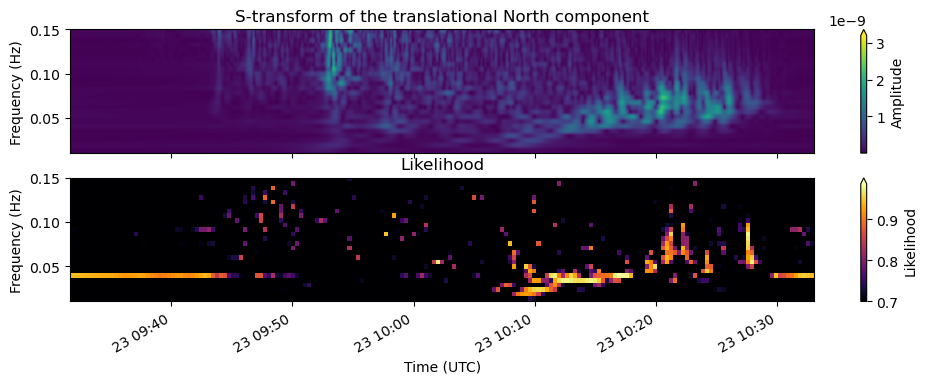

In [9]:
traN_st, f = pr.s_transform(traN[0].data, dsfacf=20) #This computes the S-transform of the translational North component


fig2, axes2 = plt.subplots(2, 1, sharex=True, figsize=(12, 4), dpi=100)

plt21 = axes2[0].imshow(np.abs(traN_st), aspect='auto',  
        extent=[date2num(pol.t_pol[0].datetime), date2num(pol.t_pol[-1].datetime), 0, 1 / pol.delta / 2],
        origin='lower', cmap='viridis') # Plot the S-transform
axes2[0].xaxis_date()
fig2.autofmt_xdate()
axes2[0].set_ylim(pol.frange)
axes2[0].set_ylabel('Frequency (Hz)')
axes2[0].set_title('S-transform of the translational North component')
cbar21 = fig2.colorbar(plt21, ax=axes2[0], extend='max')
cbar21.set_label("Amplitude")


plt22= axes2[1].imshow(lh, aspect='auto',  
        extent=[date2num(pol.t_pol[0].datetime), date2num(pol.t_pol[-1].datetime), pol.f_pol[0], pol.f_pol[-1]],
        origin='lower', cmap='inferno', vmin=0.7) # Plot the likelihood for a Rayleigh wave, clipped at 0.7
axes2[1].xaxis_date()
fig2.autofmt_xdate()
axes2[1].set_ylim(pol.frange)
axes2[1].set_ylabel('Frequency (Hz)')
axes2[1].set_title('Likelihood')
cbar22 = fig2.colorbar(plt22, ax=axes2[1], extend='max')
cbar22.set_label("Likelihood")
plt.xlabel('Time (UTC)')

Note that high likelihood values are only attained where the Rayleigh wave polarization model fits the data. The Rayleigh wave train is clearly visible arriving at about 10:10 UTC showing high likelihood values. This property can be used to automatically classify arrivals in the spectrogram in terms of their wave type. 

Note that the Rayleigh wave polarization model also seems to fit the data at random time-frequency pixels before the arrival of the Rayleigh wave train. This is likely due to noise, and can be suppressed using a smoothing filter.

Let us now inspect the extracted wave parameters (Fig. 4 in the accompanying paper):

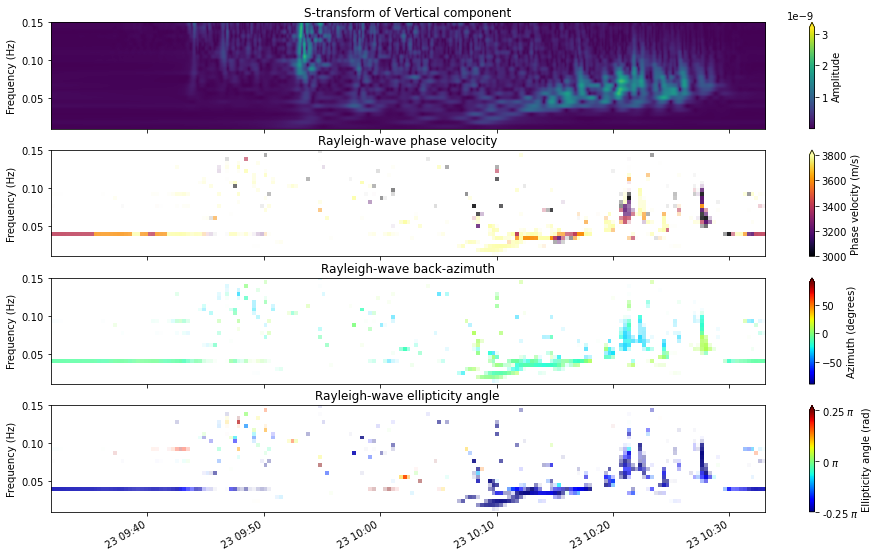

In [14]:
from matplotlib import colors # Modules needed for plotting
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as tck

alpha = colors.Normalize(vmin=0.7)(lh) # We only want to display the results where a reasonable fit of the 
                                       # Rayleigh wave polarization model to the data was found (likelihood>0.7).
                                       # To do so, we define an alpha channel that fades out all data point 
                                       # with a likelihood smaller than 0.7
alpha[alpha < 0.] = 0.
alpha[alpha > 1.] = 1.


figs, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 10))

# Plot S-transform
plot1 = axes[0].imshow(np.abs(traN_st), origin='lower', cmap='viridis', aspect='auto',
                       extent=[date2num(pol.t_pol[0].datetime), date2num(pol.t_pol[-1].datetime), 0, 1/pol.delta/2])
cbar0=figs.colorbar(plot1, ax=axes[0], extend='max')
cbar0.set_label('Amplitude')
axes[0].set_ylim(pol.frange)
axes[0].set_title("S-transform of Vertical component")
axes[0].set_ylabel("Frequency (Hz)")
axes[0].xaxis_date()


# Plot phase velocity
plt1=axes[1].imshow(vr, alpha=alpha, extent=[date2num(pol.t_pol[0].datetime), date2num(pol.t_pol[-1].datetime), pol.f_pol[0], pol.f_pol[-1]], cmap='inferno', origin='lower',
                    aspect='auto', vmin=3000, vmax=3800)
axes[1].set_title(f"Rayleigh-wave phase velocity")
axes[1].set_ylim(pol.frange)
axes[1].xaxis_date()
axes[1].set_ylabel("Frequency (Hz)")



map = ScalarMappable(colors.Normalize(vmin=3000, vmax=3800), cmap='inferno')
cbar1 = figs.colorbar(map, ax=axes[1], extend='max')
cbar1.set_label(f"Phase velocity (m/s)")

# Plot back-azimuth
plt2=axes[2].imshow(phi[:, :], alpha=alpha[:, :], extent=[date2num(pol.t_pol[0].datetime), date2num(pol.t_pol[-1].datetime), pol.f_pol[0], pol.f_pol[-1]], cmap='jet', origin='lower',
                    aspect='auto', vmin=-90, vmax=90)
axes[2].set_title(f"Rayleigh-wave back-azimuth")
axes[2].set_ylim(pol.frange)
axes[2].xaxis_date()
axes[2].set_ylabel("Frequency (Hz)")



map = ScalarMappable(colors.Normalize(vmin=-90, vmax=90), cmap='jet')
cbar2 = figs.colorbar(map, ax=axes[2], extend='max')
cbar2.set_label(f"Azimuth (degrees)")

# Plot ellipticity
plt3=axes[3].imshow(xi[:, :], alpha=alpha[:, :], extent=[date2num(pol.t_pol[0].datetime), date2num(pol.t_pol[-1].datetime), pol.f_pol[0], pol.f_pol[-1]], cmap='jet', origin='lower',
                    aspect='auto', vmin=-np.pi/4, vmax=np.pi/4)
axes[3].set_title(f"Rayleigh-wave ellipticity angle")
axes[3].set_ylim(pol.frange)
axes[3].xaxis_date()
axes[3].set_ylabel("Frequency (Hz)")



figs.autofmt_xdate()

map = ScalarMappable(colors.Normalize(vmin=-np.pi/4/np.pi, vmax=np.pi/4/np.pi), cmap='jet')
cbar3 = figs.colorbar(map, ax=axes[3], extend='max')
cbar3.set_label(f"Ellipticity angle (rad)")
cbar3.ax.yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
cbar3.ax.yaxis.set_major_locator(tck.MultipleLocator(base=0.25))

Note the dispersion characteristics that can be observed in the extracted phase velocities: events with high phase-velocities are observed arriving first at low frequencies, followed by events showing lower phase velocities at higher frequencies. 

We can also use the likelihood values obtained above to filter the data, which allows one to separate certain wave types from the seismogram. Separated data can be extracted in the following way:

In [26]:
data_sep = pol.separate('R') # Data sep is a list with six entries, containing separated data for each component

Let us now look at the separated data:

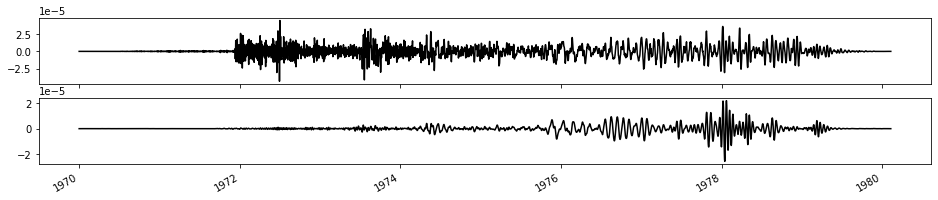

In [28]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 3))
ax[0].plot(pol.traN[0].data * v_scal, 'k')
ax[1].plot(data_sep[0] * v_scal, 'k')

Note how the high-frequency body wave phases are removed from the data, while the low-frequency Rayleigh waves remain in the separated data. 

In order to perform the separation, the estimated likelihood values need to be interpolated to the full resolution of the spectrogram. This step can result in interpolation artifacts. Using a finer sampling of the spectrograms in the analysis can help to remove these artifacts.

To exactly reproduce the processing as shown in the accompanying paper, please uncomment the following code (**Note that this will require heavy computational resources!**):

In [ ]:
#pol_paper = pr.RotPol(traN=traN, traE=traE, traZ=traZ, rotN=rotN, rotE=rotE, rotZ=rotZ, method="DOT",
#                 search='grid', delta=1., domain='f', vp_range=[6000, 8500, 250],
#                 vs_range=[2000, 4000, 200], theta_range=[0, 45, 1], phi_range=[-180, 180, 1], vr_range=[2000, 4000, 200],
#                 xi_range=[-np.pi/4, np.pi / 4, np.pi / 91], vl_range=[2000, 4000, 200], v_scal=scal, dsfacf=10, dsfact=10)
#pol_paper.estimate_all()
